In [1]:
import numpy as np

import dolfinx
import ufl
from basix.ufl import blocked_element, element, enriched_element, mixed_element
from dolfinx.fem import Function, functionspace, dirichletbc, Expression, locate_dofs_topological
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from ufl import grad, inner, split
from dolfinx import plot
from dolfinx.nls.petsc import NewtonSolver

from tqdm import tqdm

from mpi4py import MPI
from petsc4py import PETSc

import pyvista

# Simulation Setup

In [3]:
nex = int(40)
ney = int(40)

PSRI_control = True
plot_control = False

ele_dict = {0 : "tri_P1",
            1 : "tri_P2",
            2 : "tri_P2B3",
            3 : "qua_P1",
            4 : "qua_P2"}

ele_index = 3
ele_type = ele_dict[ele_index]


if ele_type == "tri_P2B3":
    cell_type = CellType.triangle
    
elif ele_type == "tri_P2":
    cell_type = CellType.triangle

elif ele_type == "tri_P1":
    cell_type = CellType.triangle
    
elif ele_type == "qua_P2":
    cell_type = CellType.quadrilateral
    
elif ele_type == "qua_P1":
    cell_type = CellType.quadrilateral

In [4]:
from pathlib import Path

if not PSRI_control:
    results_folder = Path(f"results/nonlinear_Naghdi/non_PSRI/pinched-cylinder/{nex}_{ney}_{ele_type}")
else:
    results_folder = Path(f"results/nonlinear_Naghdi/pinched-cylinder/{nex}_{ney}_{ele_type}")
    
results_folder.mkdir(exist_ok=True, parents=True)

if plot_control:
    pyvista.start_xvfb()

# Mesh

In [5]:
r = 100.0
L = 200.0 / 2 

mesh = create_rectangle(MPI.COMM_WORLD, np.array([[0.0, 0.0], [r * np.pi / 2, L]]),
                        [nex, ney], cell_type)
tdim = mesh.topology.dim
fdim = tdim - 1

cell = mesh.basix_cell()
P1 = element("Lagrange", cell, degree=1)
P2 = element("Lagrange", cell, degree=2)
B3 = element("Bubble", cell, degree=3)

## plot mesh

In [6]:
topology, cell_types, geometry = plot.vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid, show_edges=True)
plotter.show_grid()
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"mesh_rank{mesh.comm.rank}.png")

plotter.close()

Widget(value='<iframe src="http://localhost:33501/index.html?ui=P_0x7f3c0851e150_0&reconnect=auto" class="pyvi…

# Material

In [6]:
E, nu = 30.0E3, 0.3
mu = E/(2.0*(1.0 + nu)) 
lmbda = 2.0*mu*nu/(1.0 - 2.0*nu) 
t = 1.0 

# Initial shape

In [7]:
x = ufl.SpatialCoordinate(mesh)
phi0_ufl = ufl.as_vector([r * ufl.sin(x[0] / r), x[1], r * ufl.cos(x[0] / r)])

def unit_normal(phi):
    n = ufl.cross(phi.dx(0), phi.dx(1))
    return n/ufl.sqrt(inner(n, n))

n0_ufl = unit_normal(phi0_ufl)


def tangent_1(n):
    e2 = ufl.as_vector([0, 1, 0])
    t1 = ufl.cross(e2, n)
    t1 = t1/ufl.sqrt(inner(t1, t1))
    return t1

def tangent_2(n, t1):
    t2 = ufl.cross(n, t1)
    t2 = t2/ufl.sqrt(inner(t2, t2))
    return t2

# the analytical expression of t1 and t2
t1_ufl = tangent_1(n0_ufl)
t2_ufl = tangent_2(n0_ufl, t1_ufl)

# the analytical expression of R0
def rotation_matrix(t1, t2, n):
    R = ufl.as_matrix([[t1[0], t2[0], n[0]], 
                       [t1[1], t2[1], n[1]], 
                       [t1[2], t2[2], n[2]]])
    return R

R0_ufl = rotation_matrix(t1_ufl, t2_ufl, n0_ufl)

# Update the director with two successive elementary rotations
def director(R0, theta):
    Lm3 = ufl.as_vector([ufl.sin(theta[1])*ufl.cos(theta[0]), -ufl.sin(theta[0]), ufl.cos(theta[1])*ufl.cos(theta[0])])
    d = ufl.dot(R0, Lm3)
    return d

## Plot initial shape

In [9]:
# create a FEM interpolation of n0 and phi0
P1_d3_FS = functionspace(mesh, blocked_element(P1, shape = (3,)))

n0_P1_expr = Expression(n0_ufl, P1_d3_FS.element.interpolation_points())
n0_P1_func = Function(P1_d3_FS)
n0_P1_func.interpolate(n0_P1_expr)

phi0_P1_expr = Expression(phi0_ufl, P1_d3_FS.element.interpolation_points())
phi0_P1_func = Function(P1_d3_FS)
phi0_P1_func.interpolate(phi0_P1_expr)

topology, cell_types, geometry = plot.vtk_mesh(P1_d3_FS)

geometry_phi0_P1 = phi0_P1_func.x.array.reshape((geometry.shape[0], len(phi0_P1_func)))
geometry_n0_P1 = n0_P1_func.x.array.reshape((geometry.shape[0], len(n0_P1_func)))

grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)
grid_phi0_P1["n0"] = geometry_n0_P1
glyphs = grid_phi0_P1.glyph(orient="n0", factor=5)


plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k")
plotter.add_mesh(glyphs,  show_scalar_bar=True, scalar_bar_args={"vertical": True})
plotter.show_grid()
plotter.enable_parallel_projection()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"initial_shape_rank{mesh.comm.rank}.png")
    
plotter.close()

Widget(value='<iframe src="http://localhost:33501/index.html?ui=P_0x7f3b44062f90_0&reconnect=auto" class="pyvi…

# Shell element

In [8]:
if ele_type == "tri_P2B3":
    P2B3 = enriched_element([P2, B3])
    naghdi_shell_element = mixed_element(
        [blocked_element(P2B3, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "tri_P2":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
        )

elif ele_type == "tri_P1":
    naghdi_shell_element = mixed_element(
        [blocked_element(P1, shape=(3,)), blocked_element(P1, shape=(2,))]
    )
    
elif ele_type == "qua_P2":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "qua_P1":
    naghdi_shell_element = mixed_element(
        [blocked_element(P1, shape=(3,)), blocked_element(P1, shape=(2,))]
    )
    
naghdi_shell_FS = functionspace(mesh, naghdi_shell_element)

q_func = Function(naghdi_shell_FS) # current configuration
q_trial = ufl.TrialFunction(naghdi_shell_FS)
q_test = ufl.TestFunction(naghdi_shell_FS)

u_func, theta_func = split(q_func) # current displacement and rotation

# Shell model

In [9]:
# current deformation gradient 
F = grad(u_func) + grad(phi0_ufl) 

# current director
d = director(R0_ufl, theta_func)

# initial metric and curvature tensor a0 and b0
a0_ufl = grad(phi0_ufl).T * grad(phi0_ufl)
b0_ufl = -0.5*( grad(phi0_ufl).T * grad(n0_ufl) + grad(n0_ufl).T * grad(phi0_ufl))

def epsilon(F):
    """Membrane strain"""
    return 0.5 * (F.T * F - a0_ufl)


def kappa(F, d):
    """Bending strain"""
    return -0.5 * (F.T * grad(d) + grad(d).T * F) - b0_ufl


def gamma(F, d):
    """Transverse shear strain"""
    return F.T * d

a0_contra_ufl = ufl.inv(a0_ufl)
j0_ufl = ufl.det(a0_ufl)

i,j,l,m = ufl.indices(4)  # noqa: E741
A_contra_ufl = ufl.as_tensor( ( ((2.0*lmbda*mu) / (lmbda + 2.0*mu)) * a0_contra_ufl[i,j]*a0_contra_ufl[l,m]
                + 1.0*mu* (a0_contra_ufl[i,l]*a0_contra_ufl[j,m] + a0_contra_ufl[i,m]*a0_contra_ufl[j,l]) )
                ,[i,j,l,m])

N = ufl.as_tensor(t * A_contra_ufl[i,j,l,m] * epsilon(F)[l,m], [i,j])

M = ufl.as_tensor( (t**3 / 12.0) * A_contra_ufl[i,j,l,m]*kappa(F, d)[l,m], [i,j])

T = ufl.as_tensor( (t * mu *5.0 / 6.0) * a0_contra_ufl[i, j] * gamma(F, d)[j], [i])

psi_m = 0.5*inner(N, epsilon(F))

psi_b = 0.5*inner(M, kappa(F, d))

psi_s = 0.5*inner(T, gamma(F, d))

# Weak form Equation with PSRI

In [10]:
if ele_type == "qua_P1":
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 3})
    if PSRI_control:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 1})
    else:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 3})
        
elif ele_type == "tri_P1":
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 1})
    
else:
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})
    if PSRI_control:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    else:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})

# Calculate the factor alpha as a function of the mesh size h
h = ufl.CellDiameter(mesh)
alpha_FS = functionspace(mesh, element("DG", cell, 0))
alpha_expr = Expression(t**2 / h**2, alpha_FS.element.interpolation_points())
alpha = Function(alpha_FS)
alpha.interpolate(alpha_expr)

# Full integration part of the total elastic energy
Pi_PSRI = psi_b * ufl.sqrt(j0_ufl) * dx_f 
Pi_PSRI += alpha * psi_m * ufl.sqrt(j0_ufl) * dx_f
Pi_PSRI += alpha * psi_s * ufl.sqrt(j0_ufl) * dx_f

# Reduced integration part of the total elastic energy
Pi_PSRI += (1.0 - alpha) * psi_m * ufl.sqrt(j0_ufl) * dx_r
Pi_PSRI += (1.0 - alpha) * psi_s * ufl.sqrt(j0_ufl) * dx_r

# external work part (zero in this case)
W_ext = 0.0
Pi_PSRI -= W_ext

Residual = ufl.derivative(Pi_PSRI, q_func, q_test)
Jacobian = ufl.derivative(Residual, q_func, q_trial)

# Symmetric Boundary Conditions

In [11]:
u_FS, _ = naghdi_shell_FS.sub(0).collapse()
theta_FS, _ = naghdi_shell_FS.sub(1).collapse()

Q0 = naghdi_shell_FS.sub(0)
Q1 = naghdi_shell_FS.sub(1)

u_clamped = Function(u_FS) # default value is 0
theta_clamped = Function(theta_FS) # default value is 0

Top: $u_2 = \theta_1 = 0$

In [12]:
def top_boundary(x):
    return np.isclose(x[1], L)

top_facets = locate_entities_boundary(mesh, fdim, top_boundary)

# u2 = 0 on the top boundary
u_id = int(1)
symm_dofs_u_top = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), fdim, top_facets)
bc_u_top = dirichletbc(u_clamped, symm_dofs_u_top, Q0.sub(u_id))

# theta1 = 0 on the top boundary
theta_id = int(0)
symm_dofs_theta_top = locate_dofs_topological((Q1.sub(theta_id), theta_FS.sub(theta_id)), fdim, top_facets)
bc_theta_top = dirichletbc(theta_clamped, symm_dofs_theta_top, Q1.sub(theta_id))

Left: $u_1 = \theta_2 = 0$

In [13]:
def left_boundary(x):
    return np.isclose(x[0], 0.0)

left_facets = locate_entities_boundary(mesh, fdim, left_boundary)

# u1 = 0 on the left boundary
u_id = int(0)
symm_dofs_u_left = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), fdim, left_facets)
bc_u_left = dirichletbc(u_clamped, symm_dofs_u_left, Q0.sub(u_id))

# theta2 = 0 on the left boundary
theta_id = int(1)
symm_dofs_theta_left = locate_dofs_topological((Q1.sub(theta_id), theta_FS.sub(theta_id)), fdim, left_facets)
bc_theta_left = dirichletbc(theta_clamped, symm_dofs_theta_left, Q1.sub(theta_id))

Right: $u_3 = \theta_2 = 0$

In [14]:
def right_boundary(x):
    return np.isclose(x[0], r*np.pi/2)

right_facets = locate_entities_boundary(mesh, fdim, right_boundary)

# u3 = 0 on the right boundary
u_id = int(2)
symm_dofs_u_right = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), fdim, right_facets)
bc_u_right = dirichletbc(u_clamped, symm_dofs_u_right, Q0.sub(u_id))

# theta2 = 0 on the right boundary
theta_id = int(1)
symm_dofs_theta_right = locate_dofs_topological((Q1.sub(theta_id), theta_FS.sub(theta_id)), fdim, right_facets)
bc_theta_right = dirichletbc(theta_clamped, symm_dofs_theta_right, Q1.sub(theta_id))

# Rigid end diaphragms boundary conditions

Bottom: $u_1 = u_3 = 0$

In [15]:
def bottom_boundary(x):
    return np.isclose(x[1], 0.0)

bottom_facets = locate_entities_boundary(mesh, fdim, bottom_boundary)

# u1 = 0 on the bottom boundary
u_id = int(0)
rigid_dofs_u1_bottom = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), fdim, bottom_facets)
bc_u1_bottom = dirichletbc(u_clamped, rigid_dofs_u1_bottom, Q0.sub(u_id))

# u3 = 0 on the bottom boundary
u_id = int(2)
rigid_dofs_u3_bottom = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), fdim, bottom_facets)
bc_u3_bottom = dirichletbc(u_clamped, rigid_dofs_u3_bottom, Q0.sub(u_id))

In [16]:
bcs = [bc_u_top, bc_theta_top, 
       bc_u_left, bc_theta_left,
       bc_u_right, bc_theta_right,
       bc_u1_bottom, bc_u3_bottom]

# Point Source

In [17]:
def compute_cell_contributions(V, points):
    # Determine what process owns a point and what cells it lies within
    mesh = V.mesh
    _, _, owning_points, cells = dolfinx.cpp.geometry.determine_point_ownership(
        mesh._cpp_object, points, 1e-6)
    owning_points = np.asarray(owning_points).reshape(-1, 3)

    # Pull owning points back to reference cell
    mesh_nodes = mesh.geometry.x
    cmap = mesh.geometry.cmaps[0]
    ref_x = np.zeros((len(cells), mesh.geometry.dim),
                     dtype=mesh.geometry.x.dtype)
    for i, (point, cell) in enumerate(zip(owning_points, cells)):
        geom_dofs = mesh.geometry.dofmap[cell]
        ref_x[i] = cmap.pull_back(point.reshape(-1, 3), mesh_nodes[geom_dofs])

    # Create expression evaluating a trial function (i.e. just the basis function)
    u = ufl.TrialFunction(V.sub(0).sub(2))
    num_dofs = V.sub(0).sub(2).dofmap.dof_layout.num_dofs * V.sub(0).sub(2).dofmap.bs
    if len(cells) > 0:
        # NOTE: Expression lives on only this communicator rank
        expr = dolfinx.fem.Expression(u, ref_x, comm=MPI.COMM_SELF)
        values = expr.eval(mesh, np.asarray(cells, dtype=np.int32))
        # Strip out basis function values per cell
        basis_values = values[:num_dofs:num_dofs*len(cells)]
    else:
        basis_values = np.zeros(
            (0, num_dofs), dtype=dolfinx.default_scalar_type)
    return cells, basis_values

In [18]:
if mesh.comm.rank == 0:
    points = np.array([[0.0, L, 0.0]], dtype=mesh.geometry.x.dtype)
else:
    points = np.zeros((0, 3), dtype=mesh.geometry.x.dtype)

ps_cells, basis_values = compute_cell_contributions(naghdi_shell_FS, points)

# BB tree

In [19]:
bb_tree = dolfinx.geometry.bb_tree(mesh, 2)

bb_point_A = np.array([[0.0, L, 0.0]], dtype=np.float64)
bb_point_B = np.array([[r*np.pi/2, L, 0.0]], dtype=np.float64)

# Find the leaf that the target point is in
bb_cell_candidates_B = dolfinx.geometry.compute_collisions_points(bb_tree, bb_point_B)


# Find the cell from the leaf that contains the target point
bb_cells_B = dolfinx.geometry.compute_colliding_cells(
    mesh, bb_cell_candidates_B, bb_point_B)

# Solver

In [20]:
import typing
from dolfinx.fem.bcs import DirichletBC
from dolfinx.fem.function import Function as _Function
from dolfinx.fem.petsc import assemble_vector, apply_lifting, set_bc

class NonlinearProblemPointSource(NonlinearProblem):
    def __init__(self, F: ufl.form.Form, u: _Function, bcs: typing.List[DirichletBC] = [],
                 J: ufl.form.Form = None, cells = [], basis_values = [], PS: float = 0.0):
        
        super().__init__(F, u, bcs, J)
        
        self.PS = PS
        self.cells = cells
        self.basis_values = basis_values
        self.function_space = u.function_space
        
    def F(self, x: PETSc.Vec, b: PETSc.Vec) -> None:
        # Reset the residual vector
        with b.localForm() as b_local:
            b_local.set(0.0)
        assemble_vector(b, self._L)

        # Add point source
        if len(self.cells) > 0:
            for cell, basis_value in zip(self.cells, self.basis_values):
                dofs = self.function_space.sub(0).sub(2).dofmap.cell_dofs(cell)
                with b.localForm() as b_local:
                    b_local.setValuesLocal(dofs, basis_value * -self.PS, addv=PETSc.InsertMode.ADD_VALUES)
        
        # Apply boundary condition
        apply_lifting(b, [self._a], bcs=[self.bcs], x0=[x], scale=-1.0)
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b, self.bcs, x, -1.0)

In [24]:
problem = NonlinearProblemPointSource(Residual, q_func, bcs, Jacobian, ps_cells, basis_values)

solver = NewtonSolver(mesh.comm, problem)

# Set Newton solver options
solver.rtol = 1e-6
solver.atol = 1e-6
solver.max_it = 100
solver.convergence_criterion = "incremental"
solver.report = True

# Modify the linear solver in each Newton iteration
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

In [25]:
file_u = dolfinx.io.VTKFile(mesh.comm, results_folder/"u.pvd", "w")
file_theta = dolfinx.io.VTKFile(mesh.comm, results_folder/"theta.pvd", "w")
file_phi = dolfinx.io.VTKFile(mesh.comm, results_folder/"phi.pvd", "w")

def point_values():
    WA_bb = None
    UB_bb = None
    
    u1_func = q_func.sub(0).sub(0).collapse()
    u3_func = q_func.sub(0).sub(2).collapse()
    
    if len(ps_cells) > 0:
        WA_bb = u3_func.eval(bb_point_A, ps_cells[0])[0]
    WA_bb = mesh.comm.gather(WA_bb, root=0)
    
    if len(bb_cells_B.array) > 0:
        UB_bb = u1_func.eval(bb_point_B, bb_cells_B.array[0])[0]
    UB_bb = mesh.comm.gather(UB_bb, root=0)
    
    
    return WA_bb, UB_bb

In [26]:
PS_list1 = np.arange(0, -400, -40)
PS_list2 = np.arange(-400, -500, -5)
PS_list3 = np.linspace(-500, -3000, 51)
PS_list = np.hstack([PS_list1, PS_list2, PS_list3])

# PS_list = np.linspace(0, -3000, 501)
PS_max = PS_list[-1]
if mesh.comm.rank == 0:
    WA_list = np.zeros_like(PS_list)
    UB_list = np.zeros_like(PS_list)


q_func.x.array[:] = 0.0

#dolfinx.log.set_log_level(dolfinx.log.LogLevel.INFO)
#dolfinx.log.set_log_level(dolfinx.log.LogLevel.OFF)

for i, PS_curr in enumerate(tqdm(PS_list)):
    problem.PS = PS_curr
    n, converged = solver.solve(q_func)
    assert (converged)
    q_func.x.scatter_forward()
    if mesh.comm.rank == 0:
        print(f"Load step {i:d}, Number of iterations: {n:d}, Load: {problem.PS :.2f} ({PS_max})", flush=True)
    
    # write output
    if ele_type == "qua_P1" or ele_type == "tri_P1":
        phi_FS = functionspace(mesh, blocked_element(P1, shape=(3,)))
    else:
        phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
        
    if ele_type == "tri_P2B3":
        u_P2B3 = q_func.sub(0).collapse()
        u_sol = Function(phi_FS)
        u_sol.interpolate(u_P2B3)
    else:
        u_sol = q_func.sub(0).collapse()
    
    phi_expr = Expression(phi0_ufl + u_sol, phi_FS.element.interpolation_points())
    phi_sol = Function(phi_FS)
    phi_sol.interpolate(phi_expr)
    theta_sol = q_func.sub(1).collapse()

    file_u.write_function(u_sol, i)
    file_theta.write_function(theta_sol, i)
    file_phi.write_function(phi_sol, i)
    
    # calculate u3 at the point load
    WA_bb, UB_bb = point_values()
    if mesh.comm.rank == 0:
        for WA in WA_bb:
            if WA is not None:
                WA_list[i] = WA
                break
        
        for UB in UB_bb:
            if UB is not None:
                UB_list[i] = UB
                break
        


  0%|          | 0/81 [00:00<?, ?it/s]

Load step 0, Number of iterations: 2, Load: 0.00 (-3000.0)


  1%|          | 1/81 [00:10<13:43, 10.29s/it]


RuntimeError: Newton solver did not converge because maximum number of iterations reached

# Post-processing

In [24]:
u_sol = q_func.sub(0).collapse()

phi_expr = Expression(phi0_ufl + u_sol, phi_FS.element.interpolation_points())
phi_func = Function(phi_FS)
phi_func.interpolate(phi_expr)
topology, cell_types, geometry = plot.vtk_mesh(phi_FS)

geometry_phi = phi_func.x.array.reshape((geometry.shape[0], len(phi_func)))

grid_phi = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi, show_edges=True)
plotter.show_grid()
plotter.enable_parallel_projection()
plotter.show_axes_all()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/"phi.png")
plotter.close()

Widget(value='<iframe src="http://localhost:38015/index.html?ui=P_0x7f729c449640_0&reconnect=auto" class="pyvi…

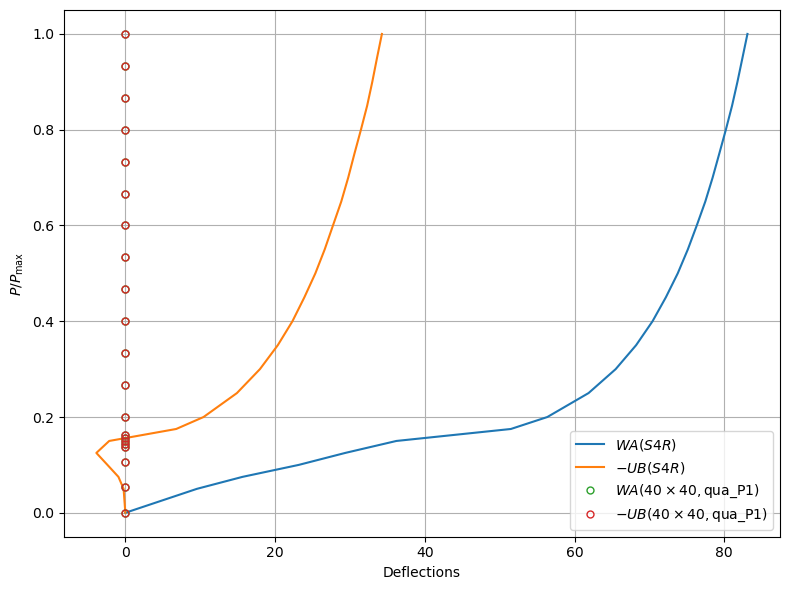

In [27]:
import matplotlib.pyplot as plt

if mesh.comm.rank == 0:
    np.savetxt(results_folder/"WA_list.txt", WA_list)
    np.savetxt(results_folder/"UB_list.txt", UB_list)
    np.savetxt(results_folder/"PS_list.txt", PS_list)
    P_S4R = np.array([0.00, 0.05, 0.075, 0.100, 0.125, 0.15, 0.175,
                      0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                      0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85,
                      0.90, 0.95, 1.00])
    
    WA_S4R = np.array([0.00, 9.561, 15.648, 23.164, 29.375, 36.208, 51.499, 56.373,
                       61.877, 65.498, 68.229, 70.424, 72.204, 73.790, 75.139, 76.331,
                       77.472, 78.451, 79.339, 80.218, 81.045, 81.766, 82.435, 83.102])
    UB_S4R = np.array([0.00, -0.233, -0.922, -2.391, -3.872, -2.154, 6.792, 10.448,
                       14.905, 17.979, 20.365, 22.321, 23.916, 25.381, 26.631, 27.735,
                       28.843, 29.772, 30.604, 31.471, 32.299, 32.989, 33.619, 34.272])
    
    np.savetxt(results_folder/"WA.txt", WA_list)
    np.savetxt(results_folder/"UB.txt", UB_list)
    np.savetxt(results_folder/"PS_Pmax.txt", PS_list/PS_max)

    plt.figure(figsize=(8.0, 6.0))
    plt.plot(WA_S4R, P_S4R, "-", label="$WA(S4R)$")
    plt.plot(UB_S4R, P_S4R, "-", label="$-UB(S4R)$")
    plt.plot(-WA_list, PS_list / PS_max, "o", markersize=5, markerfacecolor='none',
             markevery = 4, label=f"$WA({nex}\\times{ney},${ele_type})")
    plt.plot(UB_list, PS_list / PS_max, "o", markersize=5, markerfacecolor='none',
             markevery = 4, label=f"$-UB({nex}\\times{ney},${ele_type})")
    plt.xlabel("Deflections")
    plt.ylabel(r"$P/P_{\mathrm{max}}$")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(results_folder/"comparisons.png")